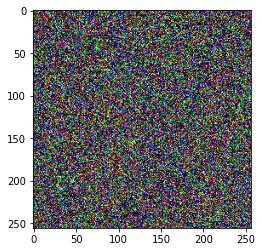

In [1]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.set_grad_enabled(False)

x = torch.randn(16, 3, 256, 256)
plt.imshow(x[0].permute(1, 2, 0))

# Fusing batch normalization and convolution in runtime
During runtime (test time, i.e., after training), the functinality of batch normalization is turned off and the approximated per-channel mean and variance are used instead. This restricted functionality can be implemented as a convolutional layer or, even better, merged with the preceding convolutional layer. This saves computational resources and simplifies the network architecture at the same time.

Refere to [this](https://nenadmarkus.com/p/fusing-batchnorm-and-conv/) blog for more details

In [2]:
rn18 = torchvision.models.resnet18(pretrained=True)
rn18.eval()
net = torch.nn.Sequential(
	rn18.conv1,
	rn18.bn1
)

In [3]:
def fuse_conv_and_bn(conv, bn):
	# init raw Conv kernels
	fusedconv = torch.nn.Conv2d(
		conv.in_channels,
		conv.out_channels,
		kernel_size=conv.kernel_size,
		stride=conv.stride,
		padding=conv.padding,
		bias=True
	)
	
	w_conv = conv.weight.clone().view(conv.out_channels, -1)
  # preparing W_BN to match first matrix in the product
	w_bn = torch.diag(bn.weight.div(torch.sqrt(bn.eps + bn.running_var)))
  # we follow the formula of fused conv weights: W_fused = W_BN * W_CONV
	fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.size()))
	
	# prepare spatial bias
	if conv.bias is not None:
		b_conv = conv.bias
	else:
		b_conv = torch.zeros(conv.weight.size(0))
  
  # preparing b_BN to match the last vector in the matrix formula
	b_bn = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps))
  # we follow the formula of fused b weights: b_fused = W_BN * b_conv + b_BN
	fusedconv.bias.copy_(torch.matmul(w_bn, b_conv) + b_bn)

	return fusedconv

In [4]:
fusedconv = fuse_conv_and_bn(net[0], net[1])
fusedconv

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))

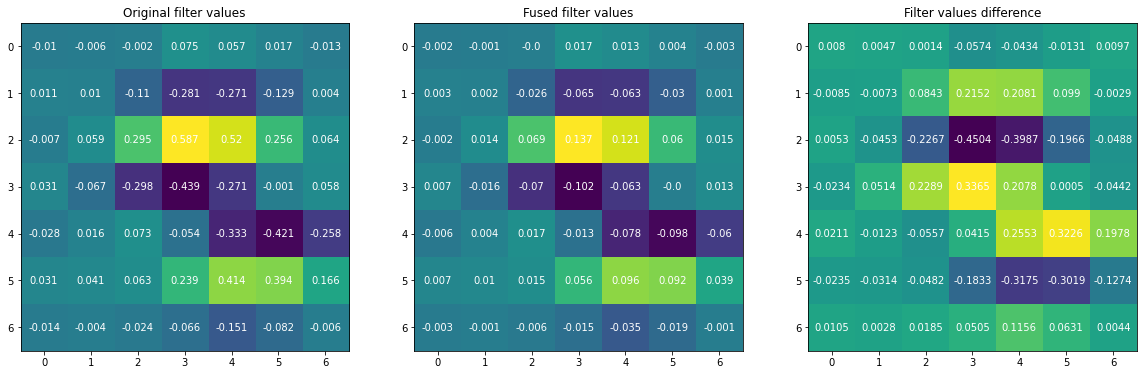

In [5]:
np.set_printoptions(suppress=True)

original_weights = net[0].weight[0][0]
fused_weights = fusedconv.weight[0][0]
value_diff = np.round((fused_weights - original_weights).numpy(), 4)

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))


ax.set_title("Original filter values")
im = ax.imshow(original_weights)
for i in range(original_weights.shape[0]):
    for j in range(original_weights.shape[1]):
        text = ax.text(j, i, np.round(original_weights[i, j].item(), 3),
                       ha="center", va="center", color="w")

ax1.set_title("Fused filter values")
im = ax1.imshow(fused_weights)
for i in range(fused_weights.shape[0]):
    for j in range(fused_weights.shape[1]):
        text = ax1.text(j, i, np.round(fused_weights[i, j].item(), 3),
                       ha="center", va="center", color="w")


ax2.set_title("Filter values difference")
im = ax2.imshow(value_diff)
for i in range(value_diff.shape[0]):
    for j in range(value_diff.shape[1]):
        text = ax2.text(j, i, value_diff[i, j],
                       ha="center", va="center", color="w")

In [6]:
y1 = net.forward(x)
fusedconv = fuse_conv_and_bn(net[0], net[1])
y2 = fusedconv.forward(x)
d = (y1 - y2).norm().div(y1.norm()).item()
print("error: %.8f" % d)

error: 0.00000030
